In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from itertools import chain 
import matplotlib.pyplot as plt


In [ ]:
# Downloading dataset
train_set = torchvision.datasets.FashionMNIST("/usr", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 


Extracting /usr/FashionMNIST/raw/train-images-idx3-ubyte.gz to /usr/FashionMNIST/raw




Extracting /usr/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /usr/FashionMNIST/raw




Extracting /usr/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /usr/FashionMNIST/raw




Extracting /usr/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /usr/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_size = 48000
val_size = 60000 - train_size

In [ ]:
train_ds,val_ds = random_split(train_set,[train_size,val_size])

In [ ]:
train_dl = DataLoader(train_ds,batch_size=20,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=20,shuffle=True)
test_dl = DataLoader(test_set,batch_size=20)

In [ ]:
loaders_scratch = {'train': train_dl, 'valid': val_dl, 'test': test_dl}

In [ ]:
classes = train_set.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

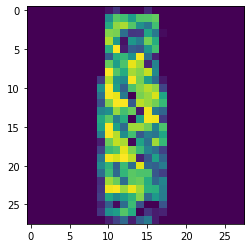

In [ ]:
import numpy as np

for imgs,labels in train_dl:
  for img in imgs:
    arr_ = np.squeeze(img) 
    #print(img.shape)
    plt.imshow(arr_)
    plt.show()
    break
  break
  #arr_ = np.squeeze(arr)
  ##plt.show()
  

In [ ]:
# Using GPU if it's available
use_cuda = torch.cuda.is_available()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #convolutional layer-1
        self.conv1 = nn.Conv2d(1,6,5, padding=0)
        #convolutional layer-2
        self.conv2 = nn.Conv2d(6,10,5,padding=0)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer 1
        self.ff1 = nn.Linear(4*4*10,56)
        # Fully connected layer 2
        self.ff2 = nn.Linear(56,10)      

    def forward(self, x):
        # adding sequence of convolutional and max pooling layers
        #input dim-28*28*1
        x = self.conv1(x)
        # After convolution operation, output dim - 24*24*6
        x = self.pool(x)
        # After Max pool operation output dim - 12*12*6
        x = self.conv2(x)
        # After convolution operation  output dim - 8*8*10
        x = self.pool(x)
        # max pool output = 4*4*10
        x = x.view(-1,4*4*10) # Reshaping the values to a shape appropriate to the input of fully connected layer
        x = F.relu(self.ff1(x)) # Applying Relu to the output of first layer
        x = F.sigmoid(self.ff2(x)) # Applying sigmoid to the output of second layer
        return x

# create a complete CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ff1): Linear(in_features=160, out_features=56, bias=True)
  (ff2): Linear(in_features=56, out_features=10, bias=True)
)


In [ ]:
# Loss function 
import torch.nn as nn
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss()
def get_optimizer_scratch(model):
    optimizer = optim.SGD(model.parameters(),lr = 0.04)
    return optimizer

In [ ]:
# Implementing the training algorithm
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train phase #
        # setting the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        # validate the model #
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

      
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
    return model

In [ ]:
num_epochs = 15
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.778835 	Validation Loss: 1.662783
Validation loss decreased (inf --> 1.662783).  Saving model ...
Epoch: 2 	Training Loss: 1.644208 	Validation Loss: 1.634536
Validation loss decreased (1.662783 --> 1.634536).  Saving model ...
Epoch: 3 	Training Loss: 1.619024 	Validation Loss: 1.609387
Validation loss decreased (1.634536 --> 1.609387).  Saving model ...
Epoch: 4 	Training Loss: 1.607973 	Validation Loss: 1.605509
Validation loss decreased (1.609387 --> 1.605509).  Saving model ...
Epoch: 5 	Training Loss: 1.600853 	Validation Loss: 1.602007
Validation loss decreased (1.605509 --> 1.602007).  Saving model ...
Epoch: 6 	Training Loss: 1.595878 	Validation Loss: 1.601091
Validation loss decreased (1.602007 --> 1.601091).  Saving model ...
Epoch: 7 	Training Loss: 1.592298 	Validation Loss: 1.600520
Validation loss decreased (1.601091 --> 1.600520).  Saving model ...
Epoch: 8 	Training Loss: 1.588808 	Validation Loss: 1.597082
Validation loss decreased (1.60052

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred)),axis=1).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test Loss: 1.584286


Test Accuracy: 77% (7745/10000)


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # printing the image
    plt.imshow(img.squeeze( ))
    #returning the class label related to the image
    return train_set.classes[preds[0].item()]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


'Sneaker'

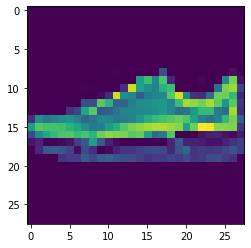

In [ ]:
img,label = test_set[9]
predict_image(img,model_scratch)